In [1]:
#import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import re
import shap
shap.initjs()

# 1. Comment Data

In [2]:
data_comment = pd.read_csv('./data/commentTestData.csv', error_bad_lines=False, sep='\t')

In [3]:
data_comment.head()

,Id,PostId,Score,Text,CreationDate,UserId,link,outdated (manually checked),description,link outdated,...,phrases,strucutures,point out deprecated version,provide alternatives,share a link,provide code,others,other notes,link to updated post,for question (1) / for answer (2)
0,29746988,5502390,2,The test page http://blog.kosny.com/testpages/...,2013-11-14T15:46:55.083,595094,https://stackoverflow.com/questions/5502390,True,code format in answer outdated,0.0,...,NaN,NaN,1.0,1.0,1.0,0.0,0.0,NaN,NaN,2.0
1,22037703,15550433,0,@believeme That example uses deprecated mysql ...,2013-03-21T15:32:21.667,790224,https://stackoverflow.com/questions/15550433,True,another comment outdated,0.0,...,NaN,NaN,1.0,0.0,0.0,0.0,0.0,outdated mysql library,NaN,1.0
2,58927510,33262467,1,"This is the best answer now, as aws 1 is depre...",2016-02-25T09:05:49.150,993592,https://stackoverflow.com/questions/33262467,True,comment in one answer to point out another ans...,0.0,...,NaN,NaN,1.0,0.0,0.0,0.0,0.0,NaN,NaN,2.0
3,102026242,42477724,1,"Is this still meant to work, because it appear...",2019-09-04T23:18:00.197,3674263,https://stackoverflow.com/questions/42477724,False,asks for possible outdated version,0.0,...,possibly outdated,NaN,1.0,0.0,0.0,0.0,0.0,NaN,NaN,2.0
4,111893971,63275335,0,Hi. I tried /home/webapp as well and that didn...,2020-08-06T06:06:30.027,1304505,https://stackoverflow.com/questions/63275335,False,asks for possible outdated version,0.0,...,seems to be outdated,NaN,1.0,0.0,0.0,0.0,0.0,NaN,NaN,2.0


In [4]:
data_comment.columns

Index(['Id', 'PostId', 'Score', 'Text', 'CreationDate', 'UserId', 'link',
       'outdated (manually checked)', 'description', 'link outdated',
       'answer outdated', 'question outdated', 'already outdated when posted',
       'other reasons', 'uncertain', 'partly outdated', 'totally outdated',
       'is aws-related', 'related service', 'keywords', 'phrases',
       'strucutures', 'point out deprecated version', 'provide alternatives',
       'share a link', 'provide code', 'others', 'other notes',
       'link to updated post', 'for question (1) / for answer (2)'],
      dtype='object')

In [5]:
#drop unuseful features
data_comment = data_comment.drop(columns=['description', 'uncertain', 'phrases', 'strucutures', 
                                          'other notes', 'link to updated post'])

In [6]:
data_comment.head()

,Id,PostId,Score,Text,CreationDate,UserId,link,outdated (manually checked),link outdated,answer outdated,...,totally outdated,is aws-related,related service,keywords,point out deprecated version,provide alternatives,share a link,provide code,others,for question (1) / for answer (2)
0,29746988,5502390,2,The test page http://blog.kosny.com/testpages/...,2013-11-14T15:46:55.083,595094,https://stackoverflow.com/questions/5502390,True,0.0,0.0,...,1.0,no,NaN,out of date,1.0,1.0,1.0,0.0,0.0,2.0
1,22037703,15550433,0,@believeme That example uses deprecated mysql ...,2013-03-21T15:32:21.667,790224,https://stackoverflow.com/questions/15550433,True,0.0,0.0,...,0.0,no,NaN,deprecated,1.0,0.0,0.0,0.0,0.0,1.0
2,58927510,33262467,1,"This is the best answer now, as aws 1 is depre...",2016-02-25T09:05:49.150,993592,https://stackoverflow.com/questions/33262467,True,0.0,1.0,...,0.0,yes,aws-sdk-ruby,deprecated,1.0,0.0,0.0,0.0,0.0,2.0
3,102026242,42477724,1,"Is this still meant to work, because it appear...",2019-09-04T23:18:00.197,3674263,https://stackoverflow.com/questions/42477724,False,0.0,0.0,...,0.0,yes,amazon-elastic-beanstalk,outdated,1.0,0.0,0.0,0.0,0.0,2.0
4,111893971,63275335,0,Hi. I tried /home/webapp as well and that didn...,2020-08-06T06:06:30.027,1304505,https://stackoverflow.com/questions/63275335,False,0.0,0.0,...,0.0,yes,"amazon-ec2, amazon-elastic-beanstalk",outdated,1.0,0.0,0.0,0.0,0.0,2.0


## 1.1 BoW

In [7]:
#use only text as training data
X = data_comment[['Text']]
y = data_comment['outdated (manually checked)']

In [8]:
def Find(string):
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex,string)
    url_list=[x[0] for x in url]
    if len(url_list) != 0:
        return 1
    else:
        return 0
X['share_link']= X['Text'].apply(lambda x:Find(x))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
X=X['Text']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
len(X_train)

126

In [12]:
X_train = X_train.fillna('fillna')

In [13]:
count_vect = CountVectorizer(stop_words = 'english')
X_train_counts = count_vect.fit_transform(X_train)

In [14]:
X_train_counts 

<126x1122 sparse matrix of type '<class 'numpy.int64'>'
	with 2107 stored elements in Compressed Sparse Row format>

In [15]:
X_train_counts.shape

(126, 1122)

In [16]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [17]:
X_train_tfidf.shape

(126, 1122)

In [18]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)
clfLR = LogisticRegression(C=50).fit(X_train_tfidf, y_train)
decisionTree = DecisionTreeClassifier(random_state = 0)

In [19]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [20]:
explainer = shap.LinearExplainer(clfLR, X_train_tfidf, feature_dependence = 'independence')
shap_values = explainer.shap_values(X_test_tfidf)
X_test_array = (X_test_tfidf).toarray()

The option feature_dependence has been renamed to feature_perturbation!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


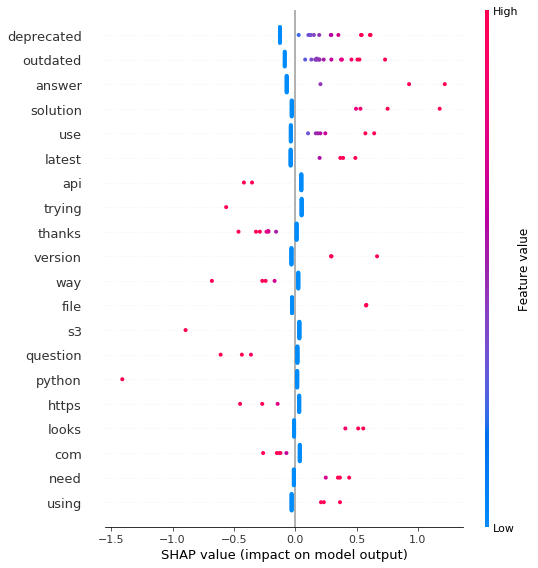

In [21]:
shap.summary_plot(shap_values, X_test_array, feature_names =count_vect.get_feature_names())

In [22]:
ind =1
shap.force_plot(
    explainer.expected_value,shap_values[ind,:],X_test_array[ind,:],
    feature_names = count_vect.get_feature_names()
)

In [23]:
# predicted = clf.predict(X_test_tfidf)
y_score_clf = clf.predict_proba(X_test_tfidf)[:, 1]
# fit(X_train_tfidf, y_train).predict_proba(X_test_tfidf)[:, 1]
y_score_clfLR = clfLR.decision_function(X_test_tfidf)
# fit(X_train_tfidf, y_train).decision_function(X_test_tfidf)

In [24]:
clf.score(X_test_tfidf, y_test)

0.71875

In [25]:
confusion_matrix(y_test, clfLR.predict(X_test_tfidf))

array([[ 0,  9],
       [ 1, 22]])

In [26]:
confusion_matrix(y_test, clfLR.predict(X_test_tfidf))

array([[ 0,  9],
       [ 1, 22]])

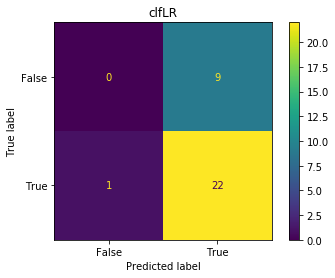

In [27]:
plot_confusion_matrix(clfLR,X_test_tfidf, y_test)
plt.title('clfLR')
plt.show()

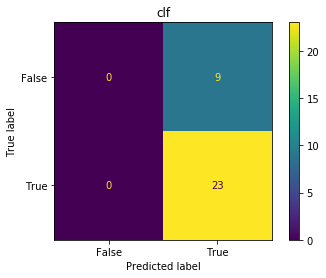

In [28]:
plot_confusion_matrix(clf,X_test_tfidf, y_test)
plt.title('clf')
plt.show()

In [29]:
fpr_clfLR, tpr_clfLR, _ = roc_curve(y_test, y_score_clfLR)
roc_auc_clfLR = auc(fpr_clfLR, tpr_clfLR)
fpr_clf, tpr_clf, _ = roc_curve(y_test, y_score_clf)
roc_auc_clf = auc(fpr_clf, tpr_clf)

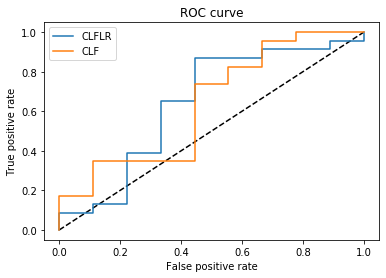

In [30]:

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_clfLR, tpr_clfLR, label='CLFLR')
plt.plot(fpr_clf, tpr_clf, label='CLF')
# plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
# plt.plot(fpr_grd, tpr_grd, label='GBT')
# plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [31]:
clfLR.score(X_test_tfidf, y_test)

0.6875

In [32]:
f1_score(y_test, clfLR.predict(X_test_tfidf))

0.8148148148148149

In [33]:
f1_score(y_test, clf.predict(X_test_tfidf))

0.8363636363636363

## 1.2 Other Features

In [34]:
X = data_comment[['Score', 'link outdated',
       'answer outdated', 'question outdated', 
       'other reasons', 'partly outdated', 'totally outdated',
       'is aws-related', 'keywords',
       'point out deprecated version', 'provide alternatives',
       'share a link', 'provide code', 'others',
       'for question (1) / for answer (2)']]
# X = data_comment[['Score', 'is aws-related', 'keywords',
#        'point out deprecated version', 'provide alternatives',
#        'share a link', 'provide code', 'others',
#        'for question (1) / for answer (2)']]
# y = data_comment['outdated (manually checked)']

In [35]:
data_comment.shape

(158, 24)

In [36]:
X['keywords']= X.keywords.str.replace(u'\xa0',u'')
X['keywords']= X.keywords.str.replace(u'depracated',u'deprecated')
X['keywords']= X.keywords.str.replace(u'obsoleted',u'obsolete')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
X[['kw1','kw2']] = X.keywords.str.split(', ',1,expand = True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
pd.unique(X['kw1'])

array(['out of date', 'deprecated', 'outdated', 'obsolete', nan,
       'probably outdated', 'remove', 'not deprecated', 'old version'],
      dtype=object)

In [39]:
pd.unique(X['kw2'])

array([None, nan, 'instead', 'old', 'deprecated'], dtype=object)

In [40]:
key_word_dummies = pd.get_dummies(X['kw1'],prefix='keyword_')
key_word_dummies2 = pd.get_dummies(X['kw2'],prefix='keyword2_')

In [41]:
X.fillna(0)
# key_word_dummies = pd.get_dummies(X.keywords, prefix='keyword_')
aws_related_dummies = pd.get_dummies(X['is aws-related'], prefix='aws_related_')
X = pd.concat([X, key_word_dummies], axis = 1)
X = pd.concat([X, key_word_dummies2], axis = 1)
X = pd.concat([X, aws_related_dummies], axis = 1)
X = X.drop(columns = 'keywords')
X = X.drop(columns = 'is aws-related')


In [44]:
def combine_deprecated(k1,k2):
    if k1 ==1 or k2 == 1:
        return 1

X['keyword__deprecated']= pd.DataFrame(list(X.apply(lambda x:combine_deprecated(x['keyword__deprecated'],x['keyword2__deprecated']),axis = 1)))
X['aws_related__yes']= pd.DataFrame(list(X.apply(lambda x:combine_deprecated(x['aws_related__yes'],x['aws_related__1']),axis = 1)))
X['aws_related__no']= pd.DataFrame(list(X.apply(lambda x:combine_deprecated(x['aws_related__no'],x['aws_related__0']),axis = 1)))


In [45]:
X = X.drop(columns = 'keyword2__deprecated')
X = X.drop(columns = 'aws_related__1')
X = X.drop(columns = 'aws_related__0')
X = X.drop(columns = 'kw1')
X = X.drop(columns = 'kw2')

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [48]:
len(X_train)

126

In [49]:
clf = BernoulliNB().fit(X_train, y_train)
clfLR = LogisticRegression(C=50).fit(X_train, y_train)

In [50]:
X_train

,Score,link outdated,answer outdated,question outdated,other reasons,partly outdated,totally outdated,point out deprecated version,provide alternatives,share a link,...,keyword__obsolete,keyword__old version,keyword__out of date,keyword__outdated,keyword__probably outdated,keyword__remove,keyword2__instead,keyword2__old,aws_related__no,aws_related__yes
87,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.0,1.0
65,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.0,1.0
47,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,1,0,0,0,0,1.0,0.0
7,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0.0,1.0
34,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0.0,1.0
130,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0.0,1.0
44,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.0,0.0
85,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.0,1.0


In [51]:
clf.score(X_test, y_test)

0.78125

In [52]:
clfLR.score(X_test, y_test)

0.8125

In [53]:
f1_score(y_test, clf.predict(X_test))

0.8205128205128205

In [54]:
f1_score(y_test, clfLR.predict(X_test))

0.85

In [55]:
explainer = shap.LinearExplainer(clfLR, X_train, feature_dependence = 'independence')
shap_values = explainer.shap_values(X_test)
X_test_array = np.array(X_test)

The option feature_dependence has been renamed to feature_perturbation!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


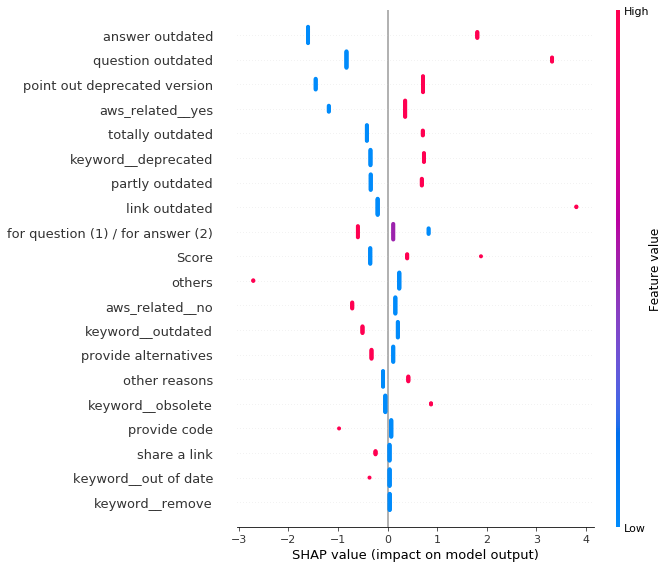

In [56]:
shap.summary_plot(shap_values, X_test)

In [57]:
shap.force_plot(explainer.expected_value, shap_values[0,:],X_test.iloc[0,:])

In [58]:
y_score_clf = clf.predict_proba(X_test)[:, 1]
# fit(X_train_tfidf, y_train).predict_proba(X_test_tfidf)[:, 1]
y_score_clfLR = clfLR.decision_function(X_test)
# fit(X_train_tfidf, y_train).decision_function(X_test_tfidf)

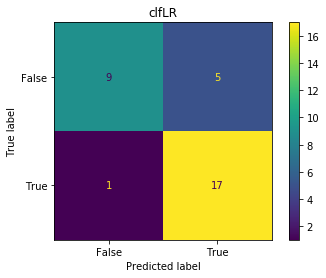

In [59]:
plot_confusion_matrix(clfLR,X_test, y_test)
plt.title('clfLR')
plt.show()

In [60]:
fpr_clfLR, tpr_clfLR, _ = roc_curve(y_test, y_score_clfLR)
roc_auc_clfLR = auc(fpr_clfLR, tpr_clfLR)
fpr_clf, tpr_clf, _ = roc_curve(y_test, y_score_clf)
roc_auc_clf = auc(fpr_clf, tpr_clf)

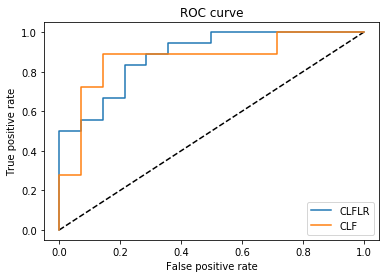

In [61]:

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_clfLR, tpr_clfLR, label='CLFLR')
plt.plot(fpr_clf, tpr_clf, label='CLF')
# plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
# plt.plot(fpr_grd, tpr_grd, label='GBT')
# plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [62]:
clf.predict(X_test)

array([ True,  True, False, False,  True,  True, False,  True, False,
        True,  True, False, False,  True,  True, False,  True,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
        True, False,  True,  True,  True])

In [63]:
y_test

3      False
132     True
43     False
14     False
50     False
107     True
88     False
120     True
70     False
4      False
111     True
16     False
13      True
27     False
23      True
131    False
128     True
59      True
30      True
125    False
18      True
1       True
48     False
37      True
98      True
154     True
77     False
63      True
45     False
62      True
68      True
82      True
Name: outdated (manually checked), dtype: bool

# 2. Answer Data

In [64]:
data_answer = pd.read_csv('./data/AnswerTestData_1.csv', encoding="ISO-8859-1")

## 2.1 BoW

In [65]:
#use only text as training data
X = data_answer['Text']
y = data_answer['outdated (manually checked)']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [67]:
X_train = X_train.fillna('fillna')
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [68]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)
clfLR = LogisticRegression(C=50).fit(X_train_tfidf, y_train)

In [69]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [70]:
clf.score(X_test_tfidf, y_test)

0.6

In [71]:
clfLR.score(X_test_tfidf, y_test)

0.75

In [72]:
f1_score(y_test, clf.predict(X_test_tfidf))

0.7499999999999999

In [73]:
f1_score(y_test, clfLR.predict(X_test_tfidf))

0.8275862068965517

## 2.2 Other Features

In [60]:
data_answer.columns

Index(['Unnamed: 0', 'Id', 'PostId', 'link', 'outdated (manually checked)',
       'description', 'link outdated', 'answer outdated',
       'service in question outdated', 'other reasons', 'partly outdated',
       'totally outdated', 'is aws-related', 'related service', 'keywords',
       'phrases', 'strucutures', 'point out deprecated version',
       'provide alternatives', 'share a link', 'provide code', 'others',
       'Text'],
      dtype='object')

In [61]:
X = data_answer[['link outdated',
       'answer outdated', 'service in question outdated', 'other reasons',
       'partly outdated', 'totally outdated', 'is aws-related',
       'keywords', 
       'point out deprecated version', 'provide alternatives', 'share a link',
       'provide code', 'others']]
y = data_answer['outdated (manually checked)']

In [62]:
X.fillna('0')
key_word_dummies = pd.get_dummies(X.keywords, prefix='keyword_')
aws_related_dummies = pd.get_dummies(X['is aws-related'], prefix='aws_related_')
X = pd.concat([X, key_word_dummies], axis = 1)
X = pd.concat([X, aws_related_dummies], axis = 1)
X = X.drop(columns = 'keywords')
X = X.drop(columns = 'is aws-related')

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [64]:
X_train = X_train.fillna('0')
X_test = X_test.fillna('0')

In [65]:
clf = BernoulliNB().fit(X_train, y_train)

In [66]:
clf.score(X_test, y_test)

0.95

In [67]:
f1_score(y_test, clf.predict(X_test))

0.9565217391304348

# 3. Combined Data (Comment&Answer)

In [68]:
data_comment.columns

Index(['Id', 'PostId', 'Score', 'Text', 'CreationDate', 'UserId', 'link',
       'outdated (manually checked)', 'link outdated', 'answer outdated',
       'question outdated', 'already outdated when posted', 'other reasons',
       'partly outdated', 'totally outdated', 'is aws-related',
       'related service', 'keywords', 'point out deprecated version',
       'provide alternatives', 'share a link', 'provide code', 'others',
       'for question (1) / for answer (2)'],
      dtype='object')

In [69]:
data_answer.columns

Index(['Unnamed: 0', 'Id', 'PostId', 'link', 'outdated (manually checked)',
       'description', 'link outdated', 'answer outdated',
       'service in question outdated', 'other reasons', 'partly outdated',
       'totally outdated', 'is aws-related', 'related service', 'keywords',
       'phrases', 'strucutures', 'point out deprecated version',
       'provide alternatives', 'share a link', 'provide code', 'others',
       'Text'],
      dtype='object')

In [70]:
data_comment['is_comment'] = 1
data_answer['is_comment'] = 0

In [71]:
data = pd.concat([data_comment, data_answer], axis = 0, join = 'inner')

In [72]:
len(data)

258

In [73]:
data.columns

Index(['Id', 'PostId', 'Text', 'link', 'outdated (manually checked)',
       'link outdated', 'answer outdated', 'other reasons', 'partly outdated',
       'totally outdated', 'is aws-related', 'related service', 'keywords',
       'point out deprecated version', 'provide alternatives', 'share a link',
       'provide code', 'others', 'is_comment'],
      dtype='object')

## 3.1 BoW

In [74]:
#use only text as training data
X = data['Text']
y = data['outdated (manually checked)']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [76]:
X_train = X_train.fillna('fillna')
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [77]:
len(X_train)

232

In [78]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)
clfLR = LogisticRegression(C=50).fit(X_train_tfidf, y_train)

In [79]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [80]:
clf.score(X_test_tfidf, y_test)

0.6153846153846154

In [81]:

clfLR.score(X_test_tfidf, y_test)

0.7307692307692307

In [82]:
f1_score(y_test, clf.predict(X_test_tfidf))

0.761904761904762

In [83]:
f1_score(y_test, clfLR.predict(X_test_tfidf))

0.8205128205128205

## 3.2 Other Features

In [84]:
X = data[['link outdated',
       'answer outdated', 'other reasons', 'partly outdated',
       'totally outdated', 'is aws-related', 'keywords',
       'point out deprecated version', 'provide alternatives', 'share a link',
       'provide code', 'others', 'is_comment']]
y = data['outdated (manually checked)']

In [85]:
X.fillna('0')
key_word_dummies = pd.get_dummies(X.keywords, prefix='keyword_')
aws_related_dummies = pd.get_dummies(X['is aws-related'], prefix='aws_related_')
X = pd.concat([X, key_word_dummies], axis = 1)
X = pd.concat([X, aws_related_dummies], axis = 1)
X = X.drop(columns = 'keywords')
X = X.drop(columns = 'is aws-related')

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [87]:

X_train = X_train.fillna('0')
X_test = X_test.fillna('0')

In [88]:
clf = BernoulliNB().fit(X_train, y_train)

In [89]:
clf.score(X_test, y_test)

0.8269230769230769

In [90]:
f1_score(y_test, clf.predict(X_test))

0.88


## 3.3 Predictions on Other Data (Answer)

In [76]:
answer_data = pd.read_csv('./data/stackoverflow_amazon_a_outdated.csv', encoding="ISO-8859-1")
answer_test_data = pd.read_csv('./data/AnswerTestData_1.csv', encoding="ISO-8859-1")

In [77]:
row_indices = []
for i in range(len(answer_data)):
    for j in range(len(answer_test_data)):
        if answer_data.iloc[i]['Id'] == answer_test_data.iloc[j]['Id']:
            row_indices.append(i)

In [78]:
answer_predict_data = answer_data.drop(row_indices)

In [79]:
len(answer_predict_data)

807

In [80]:
#use only text as training data
X = data['Text']
y = data['outdated (manually checked)']

predictions = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1)
    X_train = X_train.fillna('fillna')
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

    clf = LogisticRegression(C=50).fit(X_train_tfidf, y_train)

    X_test = answer_predict_data['Body']
    X_test_counts = count_vect.transform(X_test)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)

    prediction = clf.predict(X_test_tfidf)
    predictions.append(prediction)

NameError: name 'data' is not defined

In [ ]:
counts = np.sum(predictions, axis = 0)

In [ ]:
for i in range(len(counts)):
    if counts[i] == 5:
        prediction[i] = True
    else:
        prediction[i] = False

In [ ]:
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

In [ ]:
answer_test_data['outdated (manually checked)'].value_counts()

In [ ]:
data['outdated (manually checked)'].value_counts()

In [ ]:
answer_predict_data['prediction'] = prediction

In [ ]:
answer_predict_data.head()

In [74]:
answer_predict_data.to_csv('./data/answer_prediction_by_model.csv')

NameError: name 'answer_predict_data' is not defined

## 3.4 Predictions on Other Data (Comment)

In [75]:
answer_comment_data = pd.read_csv('./data/stackoverflow_amazon_a_comment_outdated.csv', encoding="ISO-8859-1")
question_comment_data = pd.read_csv('./data/stackoverflow_amazon_q_comment_outdated.csv', encoding="ISO-8859-1")
comment_test_data = pd.read_csv('./data/commentTestData.csv',error_bad_lines=False, sep='\t')

FileNotFoundError: [Errno 2] File b'stackoverflow_amazon_a_comment_outdated.csv' does not exist: b'stackoverflow_amazon_a_comment_outdated.csv'

In [268]:
comment_data = pd.concat([answer_comment_data, question_comment_data], axis = 0)
comment_test_data = data_comment

In [254]:
comment_data.columns

Index(['Id', 'PostId', 'Score', 'Text', 'CreationDate', 'UserId', 'link',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'ContentLicense'],
      dtype='object')

In [269]:
comment_data = comment_data.drop(columns = ['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'])
comment_predict_data = comment_data

In [270]:
row_indices = []
for i in range(len(comment_data)):
    for j in range(len(comment_test_data)):
        if comment_data.iloc[i]['Id'] == comment_test_data.iloc[j]['Id']:
            comment_predict_data = comment_predict_data.drop(i)
            row_indices.append(i)

KeyError: '[561] not found in axis'

In [265]:
comment_predict_data = comment_data.drop(917)

KeyError: '[917] not found in axis'